In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import optuna
# import optuna.integration.lightgbm as lgb
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [6]:
train_df = pd.read_csv(
    'data/train.csv',
    nrows=10**7*5,
    usecols=[1, 2, 3, 4, 5, 7, 8, 9],
    dtype= {
        'timestamp': 'int64',
        'user_id': 'int32',
        'content_id': 'int16',
        'content_type_id': 'int8',
        'task_container_id': 'int16',
        'answered_correctly':'int8',
        'prior_question_elapsed_time': 'float32',
        'prior_question_had_explanation': 'boolean'
    }
)

In [7]:
questions_df = pd.read_csv(
    'data/questions.csv',                         
    usecols=[0, 3],
    dtype={
        'question_id': 'int16',
        'part': 'int8'}
)

In [8]:
lectures_df = pd.read_csv('data/lectures.csv')

In [9]:
features_df = train_df.iloc[:int(9 /10 * len(train_df))]
train_df = train_df.iloc[int(9 /10 * len(train_df)):]

In [10]:
train_questions_only_df = features_df[features_df['answered_correctly']!=-1]
grouped_by_user_df = train_questions_only_df.groupby('user_id')
user_answers_df = grouped_by_user_df.agg({'answered_correctly': ['mean', 'count', 'std', 'median', 'skew']}).copy()
user_answers_df.columns = [
    'mean_user_accuracy', 
    'questions_answered', 
    'std_user_accuracy', 
    'median_user_accuracy', 
    'skew_user_accuracy'
]

user_answers_df

,mean_user_accuracy,questions_answered,std_user_accuracy,median_user_accuracy,skew_user_accuracy
user_id,,,,,
115,0.695652,46,0.465215,1.0,-0.879359
124,0.233333,30,0.430183,0.0,1.328338
2746,0.578947,19,0.507257,1.0,-0.347892
5382,0.672000,125,0.471374,1.0,-0.741648
8623,0.642202,109,0.481566,1.0,-0.601619
...,...,...,...,...,...
952225750,0.515625,64,0.503706,1.0,-0.064041
952226158,0.791879,4310,0.406011,1.0,-1.438459
952228125,0.566667,30,0.504007,1.0,-0.283443


In [11]:
grouped_by_content_df = train_questions_only_df.groupby('content_id')
content_answers_df = grouped_by_content_df.agg({'answered_correctly': ['mean', 'count', 'std', 'median', 'skew']}).copy()
content_answers_df.columns = [
    'mean_accuracy', 
    'question_asked', 
    'std_accuracy', 
    'median_accuracy', 
    'skew_accuracy'
]

content_answers_df

,mean_accuracy,question_asked,std_accuracy,median_accuracy,skew_accuracy
content_id,,,,,
0,0.907120,3090,0.290312,1.0,-2.806526
1,0.886741,3311,0.316957,1.0,-2.441815
2,0.555795,19957,0.496890,1.0,-0.224599
3,0.776731,10194,0.416457,1.0,-1.329239
4,0.617197,14049,0.486088,1.0,-0.482273
...,...,...,...,...,...
13518,0.785340,382,0.411125,1.0,-1.395403
13519,0.587629,388,0.492897,1.0,-0.357409
13520,0.679083,349,0.467499,1.0,-0.770548


In [12]:
del features_df
del grouped_by_user_df
del grouped_by_content_df

In [13]:
features = [
    'mean_user_accuracy', 
    'questions_answered',
    'std_user_accuracy', 
    'median_user_accuracy',
    'skew_user_accuracy',
    'mean_accuracy', 
    'question_asked',
    'std_accuracy', 
    'median_accuracy',
    'prior_question_elapsed_time', 
    'prior_question_had_explanation',
    'skew_accuracy'
]

target = 'answered_correctly'

In [14]:
train_df = train_df[train_df[target] != -1]

In [15]:
train_df = train_df.merge(user_answers_df, how='left', on='user_id')
train_df = train_df.merge(content_answers_df, how='left', on='content_id')

In [16]:
train_df['prior_question_had_explanation'] = train_df['prior_question_had_explanation'].fillna(value=False).astype(bool)
train_df = train_df.fillna(value=0.5)

In [17]:
train_df = train_df[features + [target]]
train_df = train_df.replace([np.inf, -np.inf], np.nan)
train_df = train_df.fillna(0.5)

train_df

,mean_user_accuracy,questions_answered,std_user_accuracy,median_user_accuracy,skew_user_accuracy,mean_accuracy,question_asked,std_accuracy,median_accuracy,prior_question_elapsed_time,prior_question_had_explanation,skew_accuracy,answered_correctly
0,0.423077,26.0,0.503831,0.0,0.330798,0.417736,70657,0.493190,0.0,56000.0,False,0.333608,0
1,0.423077,26.0,0.503831,0.0,0.330798,0.270900,70657,0.444428,0.0,56000.0,False,1.031017,1
2,0.423077,26.0,0.503831,0.0,0.330798,0.500432,70657,0.500003,1.0,56000.0,False,-0.001727,1
3,0.423077,26.0,0.503831,0.0,0.330798,0.611036,70657,0.487518,1.0,56000.0,False,-0.455530,0
4,0.500000,0.5,0.500000,0.5,0.500000,0.613172,6848,0.487059,1.0,0.5,False,-0.464850,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4903208,0.500000,0.5,0.500000,0.5,0.500000,0.500432,70657,0.500003,1.0,34496.0,False,-0.001727,0
4903209,0.500000,0.5,0.500000,0.5,0.500000,0.270900,70657,0.444428,0.0,34496.0,False,1.031017,0
4903210,0.500000,0.5,0.500000,0.5,0.500000,0.826132,79727,0.378999,1.0,0.5,False,-1.721061,0
4903211,0.500000,0.5,0.500000,0.5,0.500000,0.419436,83791,0.493470,0.0,32000.0,False,0.326526,0


In [18]:
train_df, test_df = train_test_split(train_df, random_state=666, test_size=0.2)

In [19]:
def create_model(trial):
    num_leaves = trial.suggest_int("num_leaves", 2, 31)
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    min_child_samples = trial.suggest_int('min_child_samples', 100, 1200)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 5, 90)
    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.0001, 1.0)
    feature_fraction = trial.suggest_uniform('feature_fraction', 0.0001, 1.0)
    
    model = LGBMClassifier(
        num_leaves=num_leaves,
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_child_samples=min_child_samples, 
        min_data_in_leaf=min_data_in_leaf,
        learning_rate=learning_rate,
        feature_fraction=feature_fraction,
        random_state=666
    )
    
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(train_df[features], train_df[target])
    score = roc_auc_score(test_df[target].values, model.predict_proba(test_df[features])[:,1])
    return score

# uncomment to use optuna
# study = optuna.create_study(direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=70)
# params = study.best_params
# params['random_state'] = 666

params = {
    'bagging_fraction': 0.5817242323514327,
    'feature_fraction': 0.6884588361650144,
    'learning_rate': 0.42887924851375825, 
    'max_depth': 6,
    'min_child_samples': 946, 
    'min_data_in_leaf': 47, 
    'n_estimators': 169,
    'num_leaves': 29,
    'random_state': 666
}

#study = optuna.create_study(direction="maximize")
#study.optimize(objective, n_trials=5)
model = LGBMClassifier(**params)
model.fit(train_df[features], train_df[target])
print('LGB score: ', roc_auc_score(test_df[target].values, model.predict_proba(test_df[features])[:,1]))

[LightGBM] [Warning] feature_fraction is set=0.6884588361650144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6884588361650144
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=946 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] bagging_fraction is set=0.5817242323514327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5817242323514327
LGB score:  0.7206668859535891


In [20]:
test_df[:30]

,mean_user_accuracy,questions_answered,std_user_accuracy,median_user_accuracy,skew_user_accuracy,mean_accuracy,question_asked,std_accuracy,median_accuracy,prior_question_elapsed_time,prior_question_had_explanation,skew_accuracy,answered_correctly
885777,0.5,0.5,0.5,0.5,0.5,0.508300,2530,0.500030,1.0,24672.0,True,-0.033226,1
1726837,0.5,0.5,0.5,0.5,0.5,0.584929,16455,0.492749,1.0,22000.0,True,-0.344755,0
4889874,0.5,0.5,0.5,0.5,0.5,0.885568,5287,0.318365,1.0,16992.0,True,-2.423096,1
4187376,0.5,0.5,0.5,0.5,0.5,0.857420,3605,0.349692,1.0,24000.0,True,-2.045333,0
3569513,0.5,0.5,0.5,0.5,0.5,0.816858,9823,0.386802,1.0,20992.0,True,-1.638682,1
498141,0.5,0.5,0.5,0.5,0.5,0.727284,8100,0.445384,1.0,14000.0,True,-1.020873,1
601084,0.5,0.5,0.5,0.5,0.5,0.527761,6664,0.499266,1.0,46496.0,True,-0.111241,1
4132260,0.5,0.5,0.5,0.5,0.5,0.466591,23916,0.498893,0.0,12000.0,True,0.133942,1
2381427,0.5,0.5,0.5,0.5,0.5,0.873001,5378,0.333003,1.0,18000.0,True,-2.241062,1
3649921,0.5,0.5,0.5,0.5,0.5,0.771446,5036,0.419943,1.0,24336.0,True,-1.293286,1


In [21]:
predicts = model.predict(test_df[features])
predicts[1:30]

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0], dtype=int8)

In [23]:
model

LGBMClassifier(bagging_fraction=0.5817242323514327,
               feature_fraction=0.6884588361650144,
               learning_rate=0.42887924851375825, max_depth=6,
               min_child_samples=946, min_data_in_leaf=47, n_estimators=169,
               num_leaves=29, random_state=666)

In [24]:
get_params_model = model.get_params(deep=True)
get_params_model

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.42887924851375825,
 'max_depth': 6,
 'min_child_samples': 946,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 169,
 'n_jobs': -1,
 'num_leaves': 29,
 'objective': None,
 'random_state': 666,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'bagging_fraction': 0.5817242323514327,
 'feature_fraction': 0.6884588361650144,
 'min_data_in_leaf': 47}

In [25]:
objective = model.objective_
objective

'binary'

In [26]:
model

LGBMClassifier(bagging_fraction=0.5817242323514327,
               feature_fraction=0.6884588361650144,
               learning_rate=0.42887924851375825, max_depth=6,
               min_child_samples=946, min_data_in_leaf=47, n_estimators=169,
               num_leaves=29, random_state=666)

In [27]:
print(model.best_score_)

defaultdict(<class 'collections.OrderedDict'>, {})


In [28]:
model.classes_

array([0, 1], dtype=int8)

In [29]:
model.evals_result_

In [30]:
model.feature_importances_

array([   0,    0,    0,    0,    0,  784, 1154,  717,   18, 1323,  220,
        516])

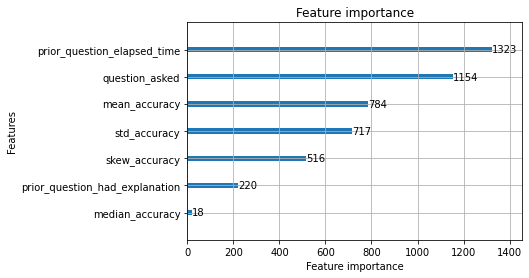

In [31]:
lgb.plot_importance(model)
plt.show()